#Apple fruit detection and counting using computer vision techniques

##Problem description

In the agricultural sector, fruit yield estimation plays a crucial role. For instance, in global food production, policymakers require the accurate estimation of fruit yield in the early stage to make timely import and export decisions (Khaki & Wang, 2019). It also helps growers improve fruit quality and reduces operating costs by making early decisions on fruit thinning. By fruit yield estimation, we can estimate the labour force for harvesting. It also benefits the food packing industry since yield estimation can have an optimized capacity planning for packing and storage (Singh & Nuske, 2012). At present, in many places, manual counting methods are used to estimate the fruit yield. Manual counting has many drawbacks, such as it is time-consuming, inaccurate results, and also it requires plenty of labour which includes labour-incentive (Syal & Garg, 2014).

##Aims and objectives

This project aims to calculate an accurate estimation of apple yield on the farm by automating the Computer Vision Techniques process.

The following measurable objectives have been identified:

1.	Fruit detection: Detecting apples in the images taken in the farms with different           scenarios such as overlapping apples, apples on the ground, different sizes of apple so on.

2.	Fruit counting: After apple detection, counting the number of apples in the dataset images will be done, which includes challenging scenarios such as clustering of apples, further distance apple images Etc.



##RCNN with VGG16


RCNN is a method where region proposals are combined with Convolutional Neural Network(CNN) model. This method takes 2000 regions using selective search process which is called region proposals, by this it avoids the problem of selecting huge number of regions which was the main issue in the earlier methods.<br>
<br>
The 2000 candidate regional proposal is taken in a square or rectangle and fed into the CNN which gives 4096-dimensional feature vector as output. CNN performs as feature extractor. Output of CNN consist of features which is extracted from the images and finally it classifies each region using  class-specific linear SVMs (Girshick, et al., 2014).<br>



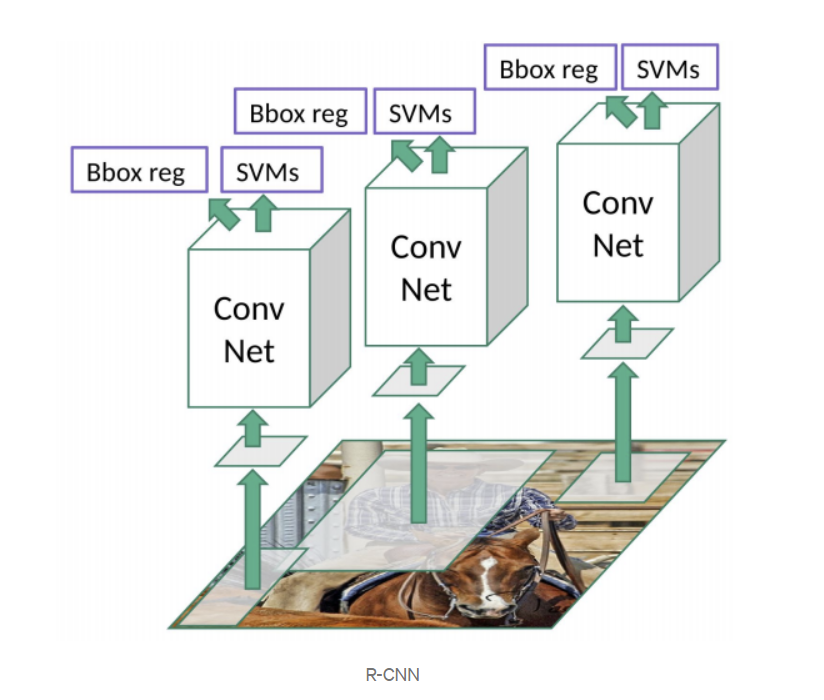

**Complete notebook should be executed in google colab with GPU enabled. The complete RCNN method used for the problem would take approximately 50 minutes to 1 hour to run.** 

##**Import libraries**

In [1]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import cv2
from torch.utils.data import DataLoader, TensorDataset
import torch
import torch.nn as nn
import torch.nn.functional as nnf
from torchvision.ops import nms

##**Mapping the Google Drive to fetch the Images and Masks**

Below code is to grant the permission for the images and masks which is saved in Google drive. The code gives the token. That token should be copied and paste it below the code. Images and masks are taken from a study called "MinneApple: A Benchmark Dataset for Apple Detection and Segmentation". (Haeni, et al., 2019). 

In [2]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

image_list and mask_list stores the information about the files inside the folders with the help of folder id.

In [3]:
image_list = drive.ListFile({'q': "'1CGe5gsgWEXX9P6hCpXJzDh4U9OI7UY1T' in parents"}).GetList()
mask_list = drive.ListFile({'q': "'1tCUg5YsEtIlAoZXAbqvwuQjQlZ2PAIg_' in parents"}).GetList()

Below code fetches all the images and masks and saves it in the lists so that, we do not have to access the drive again and again.<br>
Since this approach has disadvantage of slowness, only 109 images are taken for training and testing the data which is from the study (Haeni, et al., 2019).  <br>
In this approach, 81 images are taken as Training data, 28 images are taken as Testing data and 4 images are for counting the apples.

In [4]:
train_images = []
test_images = []
train_masks = []
test_masks = []
count_images = []
for e1, f in enumerate(image_list):
  if f['title'].startswith("Count"):
    downloaded_image = drive.CreateFile({'id':f['id']})
    downloaded_image.GetContentFile(f['title'])
    img_c = cv2.imread(f['title'])
    img_c = cv2.cvtColor(img_c, cv2.COLOR_BGR2RGB)
    count_images.append(img_c)
  for e2, m in enumerate(mask_list):
    if f['title'].startswith("Test") and f['title'].split('.')[0][5:] == m['title'].split('.')[0]:
      downloaded_test = drive.CreateFile({'id':f['id']})
      downloaded_test.GetContentFile(f['title'])
      img = cv2.imread(f['title'])
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      test_images.append(img)
      downloaded_mask = drive.CreateFile({'id':m['id']})
      downloaded_mask.GetContentFile(m['title'])
      mask = cv2.imread(m['title'])
      test_masks.append(mask)
    elif f['title'].startswith("2") and f['title'].split('.')[0] == m['title'].split('.')[0]:
      downloaded_train = drive.CreateFile({'id':f['id']})
      downloaded_train.GetContentFile(f['title'])
      img = cv2.imread(f['title'])
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      train_images.append(img)
      downloaded_mask = drive.CreateFile({'id':m['id']})
      downloaded_mask.GetContentFile(m['title'])
      mask = cv2.imread(m['title'])
      train_masks.append(mask)

In [5]:
len(train_masks)

81

##**Selective search method**

**Intersection over Union for object detection(IoU):**<br>
IoU is an evaluation metric used to measure the accuracy of an object detector on a particular image data.(Rosebrock , 2016)
<br>
<br>
It tells us how much two bounding boxes are intersected. It can be caluclated by the formula: IoU = Area of overlap/ Area of union (Rosebrock , 2016)<br>
In this solution, it helps in finding whether apple is there in the region proposals obtained from selective search method with the help of ground truth values. It contains value ranges from 0 to 1 where value closer to 1 means the region has the apple and value closer to 0 means region does not contain apple.


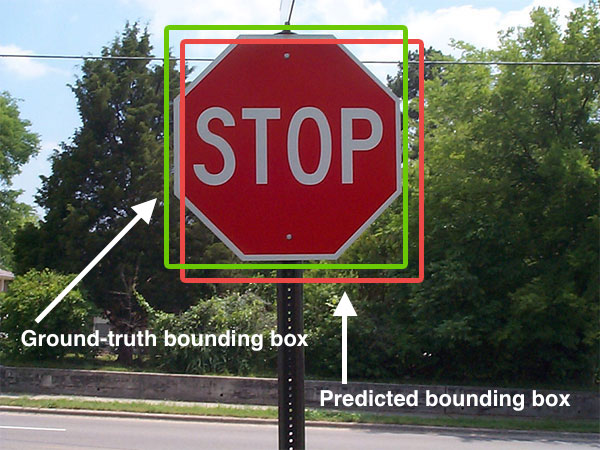

In [6]:
def find_iou(box1, box2):
    x_1 = max(box1['x1'], box2['x1'])
    y_1 = max(box1['y1'], box2['y1'])
    x_2 = min(box1['x2'], box2['x2'])
    y_2 = min(box1['y2'], box2['y2'])

    if x_2 < x_1 or y_2 < y_1:
        return 0.0
    
    intersection_area = (x_2 - x_1) * (y_2 - y_1)

    box1_area = (box1['x2'] - box1['x1']) * (box1['y2'] - box1['y1'])
    box2_area = (box2['x2'] - box2['x1']) * (box2['y2'] - box2['y1'])

    iou = intersection_area / float(box1_area + box2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

**Selective Search for Object Recognition:**<br>
Selective search works by over-segmenting an image using superpixel algorithm. (Rosebrock, 2020)<br>
It searches for an object based on 5 key similarity measure:<br>
<br>
**Color similarity:** It uses histogram intersection distance to find the color similarity between 2 regions.<br>
**Texture similarity:** Again histogram intersection is used to calculate texture similarity between two regions in a image.<br>
**Size similarity:** The size similarity metric that Selective Search performs is, it prefers that smaller regions are grouped earlier than later. By doing this we can avoid a large number of clusters from swallowing up all smaller regions.<br>
**Shape similarity/compatibility:** Selective search finds shape if two regions are compatible.<br>
**A final meta-similarity measure:** It is a linear combination of the color similarity, texture similarity, Size similarity and shape similarity. (Rosebrock, 2020)<br>
<br>
Below image is showing how selective search performs for an image.<br>
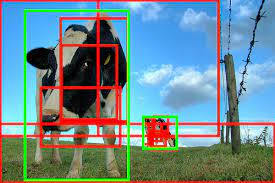

In the below cell we are initializing the selective search using opencv.

In [7]:
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

Below method performs selective search for the given images and gives the output which consist of region proposals with labels.<br>
<br>
Steps followed:<br> 

1.  For each images, take all the ground truth bounding boxes from the masks images by applying GaussianBlur and by finding the contour using opencv.
2.  Selective search performs better when noise is reduced hence for each image, noise should be reduced using fastNlMeansDenoising from opencv.
3.  Apply selective search to the images.
4.  Take result from the selective search that is in the form of x, y which is region's cordinates in an image and width, height of the regions. From this we get region proposals.
5.  Calculate IoU between ground truth bounding boxes from the first step and the result obtained from the previous step.
6. The higher the value of IoU the more chances of having the apple in the result bounding box. Hence, regions with IoU value more than 0.7 are taken as apple by labelling it as 1 and regions with IoU value lesser than 0.3 are labelled as 0.
7. All the obtained regions should be resized to 224 x 224 because only this size images are fed to vgg16 in the next step.
8. This should continue till we get enough region proposals for all the taken images.
9. At the end, we get the regions proposals with appropriate labels as output.


**Since selective search takes lot of time to execute, the below cell alone executes for 45 to 50 minutes**

In [8]:
def get_region_proposals(images,masks):
  tt_images=[]
  tt_labels =[]
  for i in range(len(images)):
    try:
      gray=cv2.cvtColor(masks[i], cv2.COLOR_BGR2GRAY)
      gray = cv2.GaussianBlur(gray, (5, 5), 0)
      cnts = cv2.findContours(gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
      bbs = pd.DataFrame([cv2.boundingRect(c) for c in cnts[0]], columns=['x','y','w','h'])
      ground_truth=[]  
      for ix, bb in bbs.iterrows():
        x1=bb.x
        x2=x1+bb.w
        y1=bb.y
        y2=y1+bb.h
        ground_truth.append({"x1":x1,"x2":x2,"y1":y1,"y2":y2})
      image_denois = cv2.fastNlMeansDenoising(images[i], h=30.0)
      ss.setBaseImage(image_denois)
      ss.switchToSelectiveSearchFast()
      ssresults = ss.process()
      img = images[i].copy()
      counter1 = 0
      counter0 = 0
      sign = 0
      sign1 = 0
      sign0 = 0
      for e,output in enumerate(ssresults):
        if e < 2000 and sign == 0:
          for g in ground_truth:
            x,y,w,h = output
            iou = find_iou(g,{"x1":x,"x2":x+w,"y1":y,"y2":y+h})
            if counter1 < 30:
              if iou > 0.70:
                small_image = img[y:y+h,x:x+w]
                small_image = cv2.resize(small_image, (224,224), interpolation = cv2.INTER_AREA)
                tt_images.append(small_image)
                tt_labels.append(1)
                counter1 += 1
              else :
                sign1 =1
            if counter0 <30:
              if iou < 0.3:
                small_image = img[y:y+h,x:x+w]
                small_image = cv2.resize(small_image, (224,224), interpolation = cv2.INTER_AREA)
                tt_images.append(small_image)
                tt_labels.append(0)
                counter0 += 1
              else :
                sign0 = 1           
          if sign1 == 1 and sign0 == 1:
            sign = 1  
    except Exception as e:
        print(e)
        continue

  return tt_images, tt_labels

Run get_region_proposals method for training and testing images and get the region proposals.

In [9]:
train_data ,train_labels  = get_region_proposals(train_images, train_masks)
test_data ,test_labels  = get_region_proposals(test_images, test_masks)

Below cell gives the number of training data and testing data which will be fed to VGG16 model.

In [10]:
len(train_data), len(test_data)

(2927, 920)

##**Train and test data**

Firstly, output from the selective search should be transpose because valid input dimension for the vgg model is 3x224x224. In this solution, it is observed model works better with batch size 30. Hence, batch size is taken as 30. Then our data should be fed to dataloader, from which data will convert into iterable over the given dataset.

In [11]:
X_train = [np.transpose(x) for x in np.array(train_data)]
X_test = [np.transpose(x) for x in np.array(test_data)]

y_train = np.array(train_labels)
y_test = np.array(test_labels)

train_data = TensorDataset(torch.from_numpy(np.array(X_train)),torch.from_numpy(y_train))
test_data = TensorDataset(torch.from_numpy(np.array(X_test)),torch.from_numpy(y_test))

batch_size = 10

train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size, drop_last=True)

##**VGG16**

VGG16 is named after the Visual Geometry Group from Oxford, who developed it. It is a convolutional neural network architecture with definite arrangement of convolution and maxpool layers with constant value for kernel, stride and padding, at the end it has two linear layers followed by softmax layer. It is referred as one of the best vision model architecture. (Simonyan & Zisserman, 2015)<br> 
<br>
The layers in vgg16 are ordered as follows:<br>
<br>

1.   Two layers of convolution layer with input image always in the shape 224x224x3 for the first layer, output channel 64, kernel is 3x3 and padding value as 1
2.   One layer of maxpool layer with 2x2 pool size and with stride 2x2
3.   Two layers of convolution layer with output channel 128, kernel is 3x3 and padding value as 1 
4.   One layer of maxpool layer with 2x2 pool size and with stride 2x2
5.   Three layers of convolution layer with output channel 256, kernel is 3x3 and padding value as 1
6.   One layer of maxpool layer with 2x2 pool size and with stride 2x2
7.   Three layers of convolution layer with output channel 512, kernel is 3x3 and padding value as 1
8.   One layer of maxpool layer with 2x2 pool size and with stride 2x2
9.   Three layers of convolution layer with output channel 512, kernel is 3x3 and padding value as 1
10.  One layer of maxpool layer with 2x2 pool size and with stride 2x2
11.  Two layers of fully connected layer
12.   One layer of softmax (Simonyan & Zisserman, 2015)<br>

In every convolution layer, relu activation function is added so that negative values should not move to next layer. (Simonyan & Zisserman, 2015)<br>






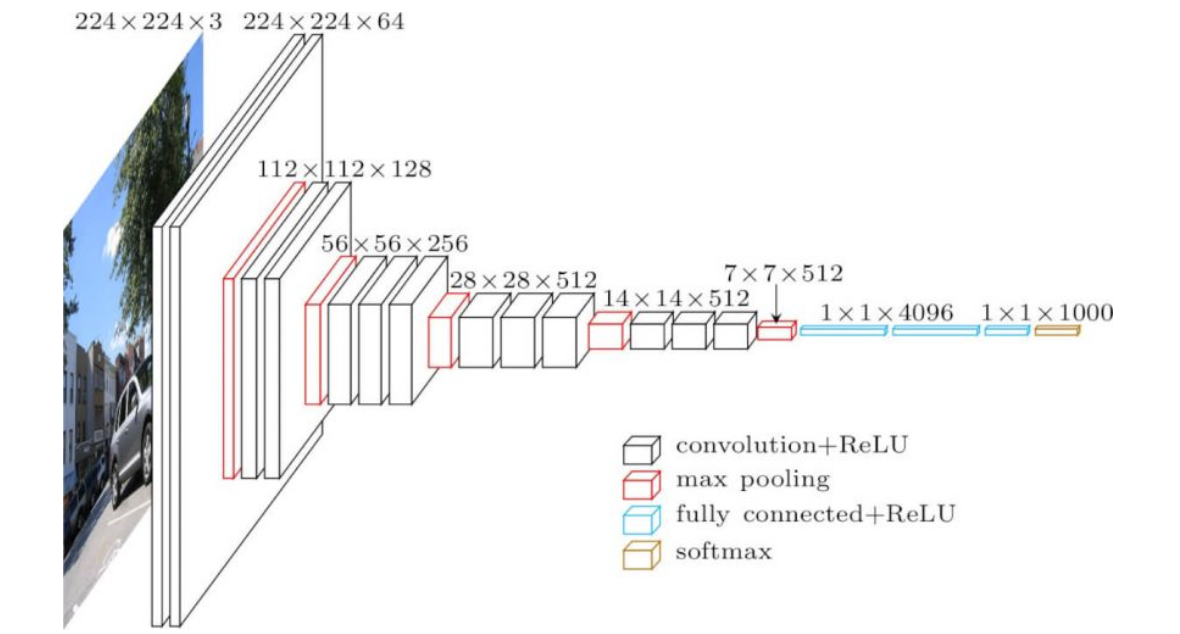

In [12]:
'''convolution_layer method takes input channel value, output channel value, 
filter size and padding size as input parameter. It performs convolution operati
on and passes through relu activation function and returns convolution layer'''

def convolution_layer(in_chann, out_chann, kernel_size, padding_size):
    convlayer = nn.Sequential(
        nn.Conv2d(in_chann, out_chann, kernel_size=kernel_size, padding=padding_size),
        nn.BatchNorm2d(out_chann),
        nn.ReLU()
    )
    return convlayer

In [13]:
'''vgg_conv_unit method takes input channel list value, output channel list value,
 filter list size , padding list size, kernel for max pooling, stride for max pooling
as input parameter. It runs convolution_layer method for all the values in the list of 
input parameters, then perform Max pooling and finally returns the output layer'''

def vgg_conv_unit(input_list, output_list, kernel_list, padding_list, k_pooling, s_pooling):
    lays = [convolution_layer(input_list[i], output_list[i], kernel_list[i], padding_list[i]) for i in range(len(input_list)) ]
    lays += [nn.MaxPool2d(kernel_size = k_pooling, stride = s_pooling)]
    return nn.Sequential(*lays)

In [14]:
'''vgg_fc_layer method takes input size and output size as input parameter and 
converts the output to linear layer, then performs Relu activation function and 
returns the output'''

def vgg_fc_layer(in_size, out_size):
    lays = nn.Sequential(
        nn.Linear(in_size, out_size),
        nn.BatchNorm1d(out_size),
        nn.ReLU()
    )
    return lays

In [15]:
'''In VGG16 class, all the layers are initializes and forward operation is performed'''

class VGG16(nn.Module):

  '''initializing all the layers'''
  def __init__(self, n_classes=2):
        super(VGG16, self).__init__()

        self.layer1 = vgg_conv_unit([3,64], [64,64], [3,3], [1,1], 2, 2)
        self.layer2 = vgg_conv_unit([64,128], [128,128], [3,3], [1,1], 2, 2)
        self.layer3 = vgg_conv_unit([128,256,256], [256,256,256], [3,3,3], [1,1,1], 2, 2)
        self.layer4 = vgg_conv_unit([256,512,512], [512,512,512], [3,3,3], [1,1,1], 2, 2)
        self.layer5 = vgg_conv_unit([512,512,512], [512,512,512], [3,3,3], [1,1,1], 2, 2)
        self.layer6 = vgg_fc_layer(7*7*512, 4096)
        self.layer7 = vgg_fc_layer(4096, 4096)
        self.layer8 = nn.Linear(4096, n_classes)

  '''performs forward operation with all the layers and returns features and 
    output layer'''
  def forward(self, x):
        output = self.layer1(x)
        output = self.layer2(output)
        output = self.layer3(output)
        output = self.layer4(output)
        features = self.layer5(output)
        output = features.view(output.size(0), -1)
        output = self.layer6(output)
        output = self.layer7(output)
        output = self.layer8(output)

        return features, output

Initializing the class VGG16 with the number of classes 2 because in this problem, 
we have 2 classes, first being apple and second being background.

In [16]:
'''Initializing the class VGG16 with number of classes 2 because in this problem, 
we have 2 classes, first being apple and second being anything but apple''' 

vgg16 = VGG16(n_classes=2)
vgg16.cuda()

VGG16(
  (layer1): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
 

##**Train the model**

Initialize the optimizer with learning rate 0.0001<br>
cost as cross entropy loss

In [17]:
optimizer = torch.optim.Adam(vgg16.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)
cost = nn.CrossEntropyLoss()

Below code is for training the vgg16 model. <br>
Step 1: Initializing the epochs as 13 because it was observed that after 13 there was no improvement in the loss<br>
Step 2: Looping through each images and labels from train_loader<br>
Step 3: Get the output from the vgg16 model by performing forward operation<br>
Step 4: Calculate the loss<br>
Step 5: Display the average loss with Epoch<br>
Step 6: Compute gradient of loss with respect to all the parameter<br>
Step 7: Updates all the weights based on the gradient of loss with learning rate<br>
Step 8: This repeats for the mentioned number of epochs<br>

In [18]:
epochs = 13
for epoch in range(epochs):
    average_loss = 0
    count = 0
    for images, labels in train_loader:
        images = images.float()
        images = images.cuda()
        labels = labels.cuda()
        optimizer.zero_grad()
        _, outputs = vgg16(images)
        loss = cost(outputs, labels)
        average_loss += loss.data
        count += 1
        print("[EPOCH: %d] average loss: %f" % (epoch, average_loss/count))
        loss.backward()
        optimizer.step()
    scheduler.step(average_loss)

[EPOCH: 0] average loss: 1.179042
[EPOCH: 0] average loss: 1.619628
[EPOCH: 0] average loss: 1.402165
[EPOCH: 0] average loss: 1.302935
[EPOCH: 0] average loss: 1.149693
[EPOCH: 0] average loss: 1.022015
[EPOCH: 0] average loss: 0.974604
[EPOCH: 0] average loss: 0.892363
[EPOCH: 0] average loss: 0.839025
[EPOCH: 0] average loss: 0.847997
[EPOCH: 0] average loss: 0.833073
[EPOCH: 0] average loss: 0.805005
[EPOCH: 0] average loss: 0.774187
[EPOCH: 0] average loss: 0.733662
[EPOCH: 0] average loss: 0.704078
[EPOCH: 0] average loss: 0.694344
[EPOCH: 0] average loss: 0.670408
[EPOCH: 0] average loss: 0.647187
[EPOCH: 0] average loss: 0.622285
[EPOCH: 0] average loss: 0.600692
[EPOCH: 0] average loss: 0.579419
[EPOCH: 0] average loss: 0.581509
[EPOCH: 0] average loss: 0.574370
[EPOCH: 0] average loss: 0.572842
[EPOCH: 0] average loss: 0.551397
[EPOCH: 0] average loss: 0.574283
[EPOCH: 0] average loss: 0.576315
[EPOCH: 0] average loss: 0.563617
[EPOCH: 0] average loss: 0.552301
[EPOCH: 0] ave

##**Test the model**

Below code is for testing the model with test data.<br>
1. Images will be tested with vgg16.eval() because in this code, we are evaluating the model.<br>
2. For each images and labels in test_loader.<br>
3. Find the output from the model.<br>
4. Predict the label by taking the index of max value from the output list. Predicted label would be either 0 or 1.<br>
5. Display the predicted label for each image, actual label for each image, number of correctly predicted and total number of images. The number in correctly predicted and total number of images will increase for every loop.<br>
6. Display the Average accuracy for each batch.<br>


In [19]:
vgg16.eval()
correct_pred = 0
total_imgs = 0

for images, labels in test_loader:
    images = images.float()
    images = images.cuda()
    _, out = vgg16(images)
    _, pred = torch.max(out.data, 1)
    total_imgs += labels.size(0)
    correct_pred += (pred.cpu() == labels).sum()
    print(pred, labels, correct_pred, total_imgs)
    print("Average accuracy: %f" % (100* correct_pred/total_imgs))

tensor([0, 0, 0, 0, 0, 0, 1, 0, 1, 0], device='cuda:0') tensor([0, 0, 0, 0, 0, 0, 1, 0, 1, 0]) tensor(10) 10
Average accuracy: 100.000000
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0') tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]) tensor(20) 20
Average accuracy: 100.000000
tensor([0, 0, 0, 0, 0, 0, 0, 0, 1, 0], device='cuda:0') tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]) tensor(29) 30
Average accuracy: 96.666664
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0') tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]) tensor(39) 40
Average accuracy: 97.500000
tensor([1, 0, 0, 1, 0, 0, 1, 0, 0, 0], device='cuda:0') tensor([1, 0, 0, 0, 0, 0, 1, 0, 0, 1]) tensor(47) 50
Average accuracy: 94.000000
tensor([0, 0, 1, 0, 1, 0, 1, 1, 0, 1], device='cuda:0') tensor([0, 0, 0, 0, 1, 0, 0, 0, 0, 0]) tensor(53) 60
Average accuracy: 88.333336
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0') tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]) tensor(63) 70
Average accuracy: 90.000000
tensor([0, 1, 0, 0, 0, 0, 0, 0, 1, 0], 

Average accuracy for the complete test data can be found in the last batch.<br>

In [20]:
print("Average accuracy: %f" % (100* correct_pred/total_imgs))

Average accuracy: 87.934784


##**Count the apples**

The below code is for counting the apples with the help of trained model.<br> Steps followed to count the apples are:<br>
1. Initialize total_count variable to 0.
2. Loop through each images in count_images list(this is separate images not included in train and test images.)
3. Run the model with vgg16.eval() and initialize the count = 0
4. Like in the earlier section, reduce the noise using fastNlMeansDenoising
5. Apply selective search.
6. Take the result from the selective search that is in the form of x, y which is region's cordinates in an image and width, height of the regions. This is the region proposal.
7. Resize the regions to 224 x 224 and convert it to tensor type
8. Find the output for the region from the model vgg16
9. Convert it into softmax to get the probability
10. Save the only bounding boxes which has probability more than 0.98 in the list and bounding boxes with probability lesser than 0.98 is not taken into consideration and also save the corresponding probability value in the scores list.
11. Apply Non Maximum Suppression (NMS) to get rid of overlapping bounding boxes with the help of bounding boxes from the previous step and scores list with IoU threshold 0.2
12. Draw bounding boxes obtained from NMS for the given images.
13. Calculate the count of the apple in each images by incrementing it everytime it draws the bounding boxes.
14. Display the previous step with the respective image.
15. Calculate total_count which is the summation of count of apples from all the images. 

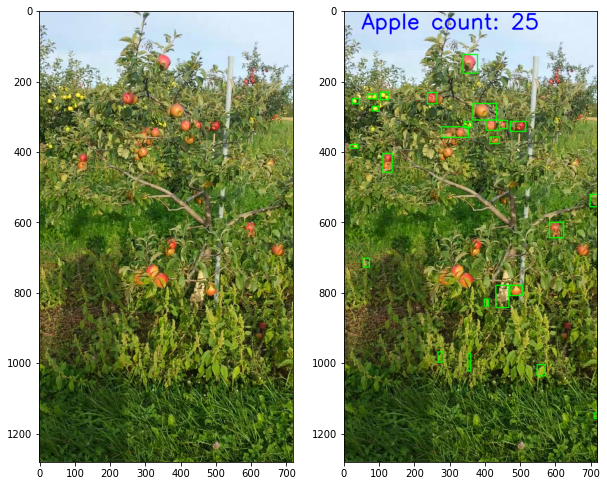

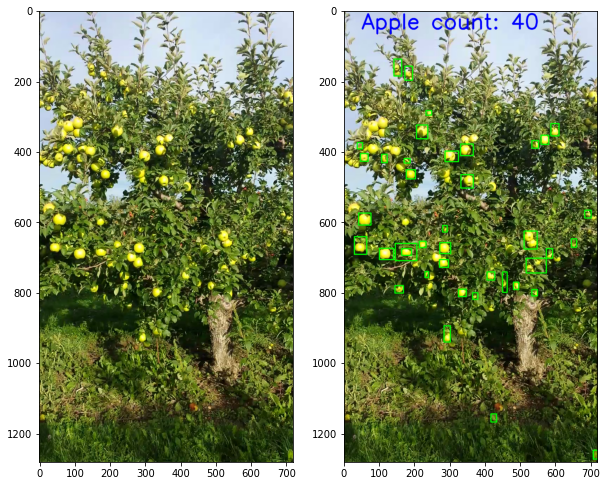

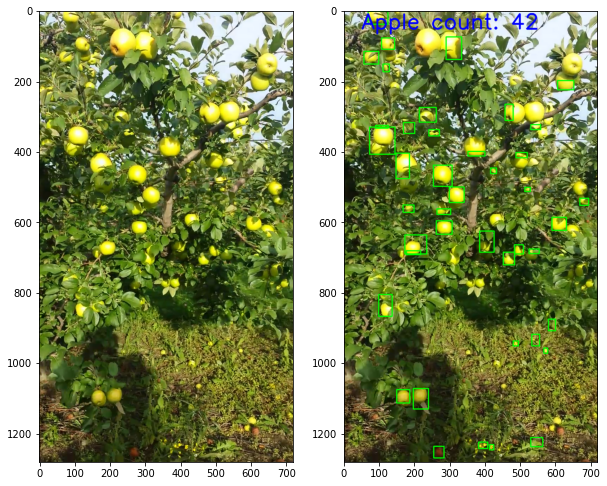

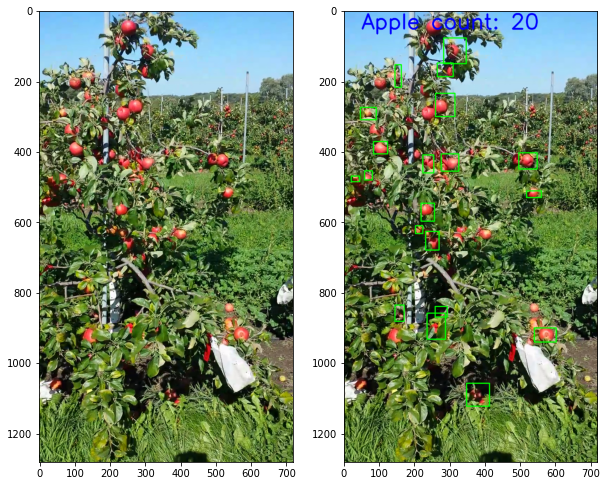

In [21]:
total_count = 0
for i in range(len(count_images)):
    vgg16.eval()
    img=None
    bboxes = {}
    scores=[]
    index=0
    count = 0
    fig = plt.figure(figsize=(10,15))
    ax1 = fig.add_subplot(1,2,1)
    ax1.imshow(count_images[i])
    img_denois = cv2.fastNlMeansDenoising(count_images[i], h=40.0)
    ss.setBaseImage(img_denois)
    ss.switchToSelectiveSearchFast()
    ssresults = ss.process()
    img = count_images[i].copy()
    for e,result in enumerate(ssresults):
      if e < 2000:
        x,y,w,h = result
        small_image = img[y:y+h,x:x+w]
        resized_small_image = cv2.resize(small_image, (224,224), interpolation = cv2.INTER_AREA)
        test_img = np.transpose(resized_small_image)
        img_exp = np.expand_dims(test_img, axis=0)
        img_tf = torch.Tensor(img_exp)
        img_tf = img_tf.cuda()
        _, out = vgg16(img_tf)
        _, predicted = torch.max(out.data, 1)
        prob = nnf.softmax(out.data, dim=1)
        if predicted == 1:
          prob2 = prob.to('cpu').numpy()[0][1]
          if prob2 > 0.98:
            bboxes[index]=([x,y,x+w,y+h])
            scores.append(prob2)
            index=index+1
    bboxes=torch.tensor(list(bboxes.values()), dtype=torch.float32)
    scores = torch.tensor(scores, dtype=torch.float32)
    if len(bboxes) == 0:
      print("No apples in the tree..")
    else:
      Nms = nms(boxes = bboxes, scores = scores, iou_threshold=0.2)
      for i in Nms.tolist():
        x1  = bboxes[i][0]
        y1 = bboxes[i][1]
        x2 = bboxes[i][2]
        y2 = bboxes[i][3]
        if abs(x2-x1)<80 and abs(y2-y1)<80:
          count = count+1
          cv2.rectangle(img,(x1, y1), (x2, y2), (0,255,0),2,cv2.LINE_AA)
    total_count = total_count + count
    cv2.putText(img,"Apple count: "+str(count), (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 255), 3,cv2.LINE_AA)
    ax2 = fig.add_subplot(1,2,2)
    ax2.imshow(img)

Finally displaying the total number of apples from all the images.

In [22]:
print("Total number of apple:"+str(total_count))

Total number of apple:127


##**Advantages and diaadvantages of using RCNN for the given problem**

**Advantages:**<br>
1. Implementation is easier compared to fast RCNN or faster RCNN
2. Better accuracy is obtained even with less images
3. Selective search used in the approach is faster than sliding window and image pyramid process. (Rosebrock 2020)

**Disadvantages:**<br>
1. Extremely slow compared to fast RCNN and Faster RCNN because of selective search method where for each image it has to take huge number of regions. 
2. Because of slowness, in this study only 110 images are taken for training and testing
3. Cuda does not support selective search in opencv. (Anon. 2021)


##**Reference**

Anon., 2021. OpenCV. [Online] 
Available at: https://docs.opencv.org/master/d1/d1e/group__cuda.html<br>
Girshick, R. et al., 2014. Rich feature hierarchies for accurate object detection and semantic segmentation. arxiv.<br>
Rosebrock , A., 2016. pyimagesearch. [Online] 
Available at: https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/<br>
Rosebrock, A., 2020. pyimagesearch. [Online] 
Available at: https://www.pyimagesearch.com/2020/06/29/opencv-selective-search-for-object-detection/<br>
Simonyan, K. & Zisserman, A., 2015. Very Deep Convolutional Networks for Large-Scale Image Recognition. arXiv.<br>
Haeni, N., Roy, P. & Isler, V., 2019. University of Minnesota library digital conservancy. [Online] 
Available at: https://conservancy.umn.edu/handle/11299/206575
<br>


